**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

# Intro to Random Forests

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import sys
sys.path.append("/Users/tlee010/Desktop/github_repos/fastai/") # go to parent dir

from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

from sklearn import metrics

/home/tom/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
PATH = "../data/mercari/"

In [4]:
!ls {PATH}

Train.tsv


In [26]:
df_raw = pd.read_csv(f'{PATH}Train.tsv', sep='\t')

In any sort of data science work, it's **important to look at your data**, to make sure you understand the format, how it's stored, what type of values it holds, etc. Even if you've read descriptions about your data, the actual data may not be what you expect.

In [6]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [7]:
display_all(df_raw.tail().T)

,1482530,1482531,1482532,1482533,1482534
train_id,1482530,1482531,1482532,1482533,1482534
name,Free People Inspired Dress,Little mermaid handmade dress,21 day fix containers and eating plan,World markets lanterns,Brand new lux de ville wallet
item_condition_id,2,2,2,3,1
category_name,Women/Dresses/Mid-Calf,Kids/Girls 2T-5T/Dresses,Sports & Outdoors/Exercise/Fitness accessories,Home/Home Décor/Home Décor Accents,Women/Women's Accessories/Wallets
brand_name,Free People,Disney,NaN,NaN,NaN
price,20,14,12,45,22
shipping,1,0,0,1,0
item_description,"Lace, says size small but fits medium perfectl...",Little mermaid handmade dress never worn size 2t,"Used once or twice, still in great shape.",There is 2 of each one that you see! So 2 red ...,"New with tag, red with sparkle. Firm price, no..."


In [8]:
display_all(df_raw.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
train_id,1.48254e+06,NaN,NaN,NaN,741267,427971,0,370634,741267,1.1119e+06,1.48253e+06
name,1482535,1225273,Bundle,2232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
item_condition_id,1.48254e+06,NaN,NaN,NaN,1.90738,0.903159,1,1,2,3,5
category_name,1476208,1287,"Women/Athletic Apparel/Pants, Tights, Leggings",60177,NaN,NaN,NaN,NaN,NaN,NaN,NaN
brand_name,849853,4809,PINK,54088,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,1.48254e+06,NaN,NaN,NaN,26.7375,38.5861,0,10,17,29,2009
shipping,1.48254e+06,NaN,NaN,NaN,0.447274,0.497212,0,0,0,1,1
item_description,1482531,1281426,No description yet,82489,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It's important to note what metric is being used for a project. Generally, selecting the metric(s) is an important part of the project setup. However, in this case Kaggle tells us what metric to use: RMSLE (root mean squared log error) between the actual and predicted auction prices. Therefore we take the log of the prices, so that RMSE will give us what we need.

In [14]:
df_raw['price'] = np.log(df_raw['price'])

/home/tom/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Initial processing

In [58]:
m = RandomForestRegressor(n_jobs=-1)
# The following code is supposed to fail due to string values in the input data
m.fit(df_raw.drop('SalePrice', axis=1), df_raw.SalePrice)

ValueError: could not convert string to float: 'Low'

This dataset contains a mix of **continuous** and **categorical** variables.

The following method extracts particular date fields from a complete datetime for the purpose of constructing categoricals.  You should always consider this feature extraction step when working with date-time. Without expanding your date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities.

In [23]:
#add_datepart(df_raw, 'saledate')
#df_raw.saleYear.head()

The categorical variables are currently stored as strings, which is inefficient, and doesn't provide the numeric coding required for a random forest. Therefore we call `train_cats` to convert strings to pandas categories.

In [32]:
train_cats(df_raw)

We can specify the order to use for categorical variables if we wish:

In [11]:
df_raw.brand_name.cat.codes

0            -1
1          3557
2          4180
3            -1
4            -1
           ... 
1482530    1641
1482531    1265
1482532      -1
1482533      -1
1482534      -1
Length: 1482535, dtype: int16

In [62]:
df_raw.brand_name.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

Normally, pandas will continue displaying the text categories, while treating them as numerical data internally. Optionally, we can replace the text categories with numbers, which will make this variable non-categorical, like so:.

In [17]:
df_raw.brand_name = df_raw.brand_name.cat.codes

AttributeError: Can only use .cat accessor with a 'category' dtype

We're still not quite done - for instance we have lots of missing values, which we can't pass directly to a random forest.

In [18]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

brand_name           0.000000
category_name        0.004268
item_condition_id    0.000000
item_description     0.000003
name                 0.000000
price                0.000000
shipping             0.000000
train_id             0.000000
dtype: float64

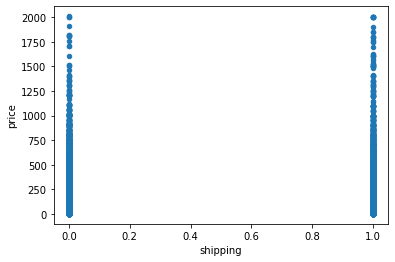

In [31]:
df_raw.plot.scatter(x='shipping', y='price')

In [ ]:
#df_raw.plot.hist(alpha=0.5)

But let's save this file for now, since it's already in format can we be stored and accessed efficiently.

In [15]:
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/mercari-raw')

### Pre-processing

In the future we can simply read it from this fast format.

In [8]:
df_raw = pd.read_feather('tmp/mercari-raw')

We'll replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable.

In [17]:
df, y, nas = proc_df(df_raw, 'price')
y_ = y[~np.isnan(y)]
y = np.nan_to_num(y, nan=y_.mean())
print(np.where(np.isinf(y)))
y_.mean()

(array([], dtype=int64),)


-inf

We now have something we can pass to a random forest!

In [ ]:
m = RandomForestRegressor(n_jobs=8)
m.fit(df, y)
m.score(df,y)

/home/tom/anaconda3/envs/fastai/lib/python3.6/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In statistics, the coefficient of determination, denoted R2 or r2 and pronounced "R squared", is the proportion of the variance in the dependent variable that is predictable from the independent variable(s). https://en.wikipedia.org/wiki/Coefficient_of_determination

Wow, an r^2 of 0.98 - that's great, right? Well, perhaps not...

Possibly **the most important idea** in machine learning is that of having separate training & validation data sets. As motivation, suppose you don't divide up your data, but instead use all of it.  And suppose you have lots of parameters:

<img src="images/overfitting2.png" alt="" style="width: 70%"/>
<center>
[Underfitting and Overfitting](https://datascience.stackexchange.com/questions/361/when-is-a-model-underfitted)
</center>

The error for the pictured data points is lowest for the model on the far right (the blue curve passes through the red points almost perfectly), yet it's not the best choice.  Why is that?  If you were to gather some new data points, they most likely would not be on that curve in the graph on the right, but would be closer to the curve in the middle graph.

This illustrates how using all our data can lead to **overfitting**. A validation set helps diagnose this problem.

In [11]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((1470535, 7), (1470535,), (12000, 7))

# Random Forests

## Base model

Let's try our model again, this time with separate training and validation sets.

In [12]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [ ]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

An r^2 in the high-80's isn't bad at all (and the RMSLE puts us around rank 100 of 470 on the Kaggle leaderboard), but we can see from the validation set score that we're over-fitting badly. To understand this issue, let's simplify things down to a single small tree.

In [12]:
??split_vals

## Speeding things up

In [20]:
df_trn, y_trn, nas = proc_df(df_raw, 'price', subset=80000, na_dict=nas)

y_ = y_trn[~np.isnan(y_trn)]
y_trn = np.nan_to_num(y, nan=y_.mean())

X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [21]:
m = RandomForestRegressor(n_jobs=8)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 18.9 s, sys: 23.1 ms, total: 18.9 s
Wall time: 2.55 s
[0.10760390583140655, 0.3444262028887433, 0.8505192017118699, -0.5269837416400864]


## Single tree

In [17]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.524145069857878, 0.5824618042392764, 0.40768438242021987, 0.3941252182401821]


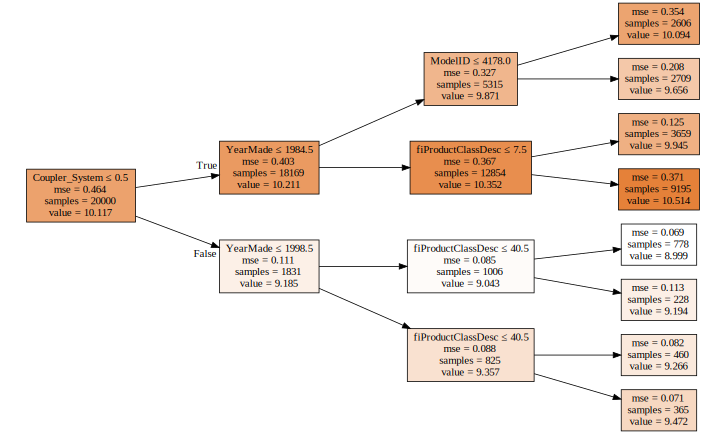

In [18]:
draw_tree(m.estimators_[0], df_trn, precision=3)

Let's see what happens if we create a bigger tree.

In [19]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[6.526751786450488e-17, 0.4555561542020589, 1.0, 0.6293774754759134]


The training set result looks great! But the validation set is worse than our original model. This is why we need to use *bagging* of multiple trees to get more generalizable results.

## Bagging

### Intro to bagging

To learn about bagging in random forests, let's start with our basic model again.

In [ ]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.11745691160954547, 0.27959279688230376, 0.97139456205050101, 0.86039533492251219]


We'll grab the predictions for each individual tree, and look at one example.

In [ ]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([ 9.21034,  8.9872 ,  8.9872 ,  8.9872 ,  8.9872 ,  9.21034,  8.92266,  9.21034,  9.21034,  8.9872 ]),
 9.0700003890739005,
 9.1049798563183568)

In [ ]:
preds.shape

(10, 12000)

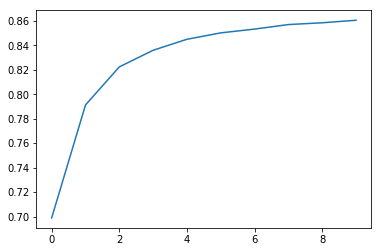

In [ ]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

The shape of this curve suggests that adding more trees isn't going to help us much. Let's check. (Compare this to our original model on a sample)

In [ ]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.10721195540628872, 0.2777358026154778, 0.9761670456844791, 0.86224362387001874]


In [ ]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.1029319603663909, 0.2725488716109634, 0.97803192843821529, 0.86734099039701873]


In [ ]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.09942284423261978, 0.27026457977935875, 0.97950425012208453, 0.86955536025947799]


### Out-of-bag (OOB) score

Is our validation set worse than our training set because we're over-fitting, or because the validation set is for a different time period, or a bit of both? With the existing information we've shown, we can't tell. However, random forests have a very clever trick called *out-of-bag (OOB) error* which can handle this (and more!)

The idea is to calculate error on the training set, but only include the trees in the calculation of a row's error where that row was *not* included in training that tree. This allows us to see whether the model is over-fitting, without needing a separate validation set.

This also has the benefit of allowing us to see whether our model generalizes, even if we only have a small amount of data so want to avoid separating some out to create a validation set.

This is as simple as adding one more parameter to our model constructor. We print the OOB error last in our `print_score` function below.

In [ ]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.10198464613020647, 0.2714485881623037, 0.9786192457999483, 0.86840992079038759, 0.84831537630038534]


This shows that our validation set time difference is making an impact, as is model over-fitting.

## Reducing over-fitting

### Subsampling

It turns out that one of the easiest ways to avoid over-fitting is also one of the best ways to speed up analysis: *subsampling*. Let's return to using our full dataset, so that we can demonstrate the impact of this technique.

In [13]:
df_trn, y_trn, nas = proc_df(df_raw, 'price')

y_ = y_trn[~np.isnan(y_trn)]
y_trn = np.nan_to_num(y, nan=y_.mean())

X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [14]:
len(X_train)

1470535

The basic idea is this: rather than limit the total amount of data that our model can access, let's instead limit it to a *different* random subset per tree. That way, given enough trees, the model can still see *all* the data, but for each individual tree it'll be just as fast as if we had cut down our dataset as before.

In [2]:
set_rf_samples(20000)

NameError: name 'set_rf_samples' is not defined

In [1]:
??set_rf_samples

Object `set_rf_samples` not found.


In [ ]:
m = RandomForestRegressor(n_jobs=8, oob_score=False)
%time m.fit(X_train, y_train)
print_score(m)

Since each additional tree allows the model to see more data, this approach can make additional trees more useful.

In [22]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=False)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 12min 52s, sys: 1.28 s, total: 12min 53s
Wall time: 1min 41s
[0.07833308470343378, 0.23615033748838435, 0.9871759475888106, 0.9004078483731599]


### Tree building parameters

We revert to using a full bootstrap sample in order to show the impact of other over-fitting avoidance methods.

In [23]:
reset_rf_samples()

Let's get a baseline for this full set to compare to.

In [24]:
def dectree_max_depth(tree):
    children_left = tree.children_left
    children_right = tree.children_right

    def walk(node_id):
        if (children_left[node_id] != children_right[node_id]):
            left_max = 1 + walk(children_left[node_id])
            right_max = 1 + walk(children_right[node_id])
            return max(left_max, right_max)
        else: # leaf
            return 1

    root_node_id = 0
    return walk(root_node_id)

In [25]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07853487987454999, 0.23822783529340286, 0.9871097899712723, 0.8986478460319396, 0.9082691508330323]


In [26]:
t=m.estimators_[0].tree_

In [27]:
dectree_max_depth(t)

45

In [29]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.14071630959681408, 0.2337341280797342, 0.9586168352661985, 0.9024354079891104, 0.9069491625996906]


In [ ]:
t=m.estimators_[0].tree_

In [ ]:
dectree_max_depth(t)

35

Another way to reduce over-fitting is to grow our trees less deeply. We do this by specifying (with `min_samples_leaf`) that we require some minimum number of rows in every leaf node. This has two benefits:

- There are less decision rules for each leaf node; simpler models should generalize better
- The predictions are made by averaging more rows in the leaf node, resulting in less volatility

In [ ]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11595869956476182, 0.23427349924625201, 0.97209195463880227, 0.90198460308551043, 0.90843297242839738]


We can also increase the amount of variation amongst the trees by not only use a sample of rows for each tree, but to also using a sample of *columns* for each *split*. We do this by specifying `max_features`, which is the proportion of features to randomly select from at each split.

- None
- 0.5
- 'sqrt'

- 1, 3, 5, 10, 25, 100

In [ ]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11926975747908228, 0.22869111042050522, 0.97026995966445684, 0.9066000722129437, 0.91144914977164715]


We can't compare our results directly with the Kaggle competition, since it used a different validation set (and we can no longer to submit to this competition) - but we can at least see that we're getting similar results to the winners based on the dataset we have.

The sklearn docs [show an example](http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html) of different `max_features` methods with increasing numbers of trees - as you see, using a subset of features on each split requires using more trees, but results in better models:
![sklearn max_features chart](http://scikit-learn.org/stable/_images/sphx_glr_plot_ensemble_oob_001.png)